## Initial loading of libraries and dataset

In [1]:
# Connect the necessary libraries
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Rescaling, BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

In [2]:
# Load the imagenette dataset from TensorFlow Datasets
dataset, info = tfds.load("imagenette", with_info=True, as_supervised=True)

In [3]:
# Divide the dataset into training and test
train_set = dataset['train']
validation_set = dataset['validation']

In [4]:
# Convert all images to size 224x224
train_dataset = train_set.map(lambda image, label: (tf.image.resize(image, (224, 224)), label))
validation_dataset = validation_set.map(lambda image, label: (tf.image.resize(image, (224, 224)), label))

In [5]:
# Get the total number of classes
num_classes = info.features['label'].num_classes
print(f"Усього класів: {num_classes}")

# Get class names using int2str
get_label_name = info.features['label'].int2str
text_labels = [get_label_name(i) for i in range(num_classes)]
for idx, i in enumerate(text_labels):
    print(f"Class {idx}: {i}")

Усього класів: 10
Class 0: n01440764
Class 1: n02102040
Class 2: n02979186
Class 3: n03000684
Class 4: n03028079
Class 5: n03394916
Class 6: n03417042
Class 7: n03425413
Class 8: n03445777
Class 9: n03888257


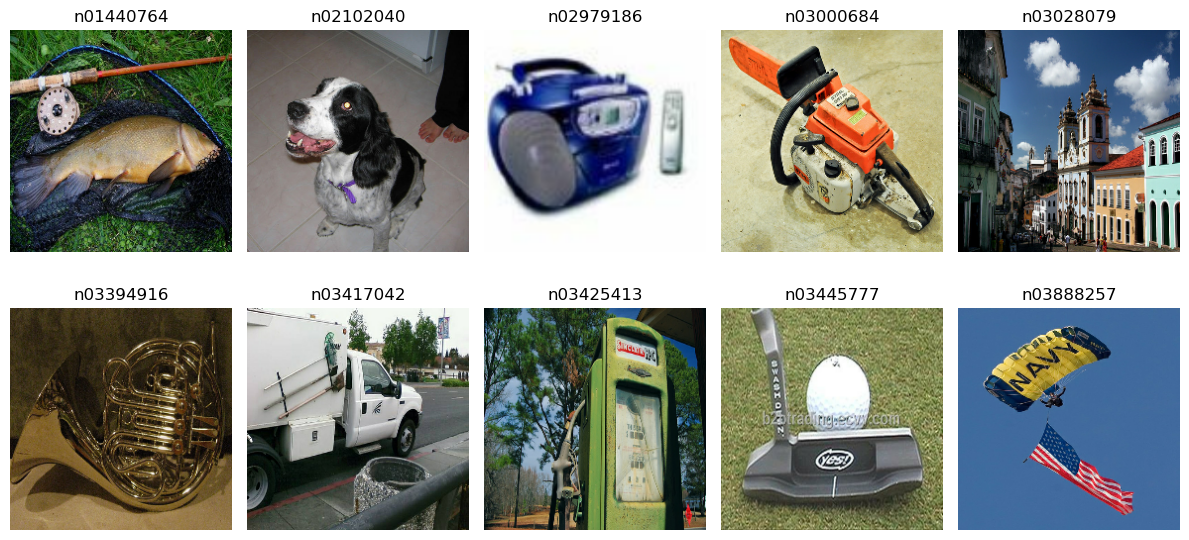

In [6]:
# Let's create a list for images and labels
images = []
labels = []

# Go through each class and get one image for each class
for i in range(num_classes):
    for image, label in train_dataset:
        if label.numpy() == i:
            images.append(image.numpy())
            labels.append(text_labels[i])
            break

# Display images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

# Output images
for i in range(len(images)):
    axes[i].imshow(images[i].astype("uint8"))
    axes[i].set_title(labels[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Data preparation

# Create lists X_train (images) and y_train (labels) from training dataset
X_train = list(map(lambda x: x[0], train_dataset))
y_train = list(map(lambda x: x[1], train_dataset))

# Create lists X_valid (images) and y_valid (labels) from validation dataset
X_valid = list(map(lambda x: x[0], validation_dataset))
y_valid = list(map(lambda x: x[1], validation_dataset))

# Convert labels (y_train and y_valid) to categorical vectors (one-hot encoding)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Create generator for training data (normalization)
train_generator = ImageDataGenerator(rescale=1. / 255)

# Create generator for validation data (normalization)
valid_generator = ImageDataGenerator(rescale=1. / 255)

train_iterator = tf.keras.preprocessing.image.NumpyArrayIterator(x=np.array(X_train), y=np.array(y_train), image_data_generator=train_generator, batch_size=32)
valid_iterator = tf.keras.preprocessing.image.NumpyArrayIterator(x=np.array(X_valid), y=np.array(y_valid), image_data_generator=valid_generator, batch_size=32)

## Working with neural network

In [8]:
# Create neural network
model = keras.models.Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # Second block
    Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # Third block
    Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),

    # Fourth block
    Conv2D(192, (3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),

    # Fifth block
    Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # Flatten and fully connected layers
    Flatten(),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [9]:
# Compile neural network
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 54, 54, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 26, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 192)         │         663,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         442,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │      13,109,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          20,4

 Total params: 19,971,914 (76.19 MB)

 Trainable params: 19,969,546 (76.18 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [10]:
# Train the model
history = model.fit(
    train_iterator,
    validation_data=valid_iterator,
    epochs=20,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)],
)

# Evaluate model on test set
loss, accuracy = model.evaluate(valid_iterator)
print(f'Accuracy: {accuracy:.3f}')

C:\Users\User\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.1782 - loss: 6.4682

C:\Users\User\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


296/296 ━━━━━━━━━━━━━━━━━━━━ 214s 713ms/step - accuracy: 0.1782 - loss: 6.4589 - val_accuracy: 0.2015 - val_loss: 2.3099
Epoch 2/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 213s 718ms/step - accuracy: 0.2686 - loss: 2.1525 - val_accuracy: 0.2731 - val_loss: 2.0222
Epoch 3/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 211s 714ms/step - accuracy: 0.3208 - loss: 2.0124 - val_accuracy: 0.3185 - val_loss: 1.9470
Epoch 4/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 210s 709ms/step - accuracy: 0.3451 - loss: 1.9466 - val_accuracy: 0.2892 - val_loss: 2.0656
Epoch 5/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 210s 711ms/step - accuracy: 0.3601 - loss: 1.8954 - val_accuracy: 0.2673 - val_loss: 2.2719
Epoch 6/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 210s 709ms/step - accuracy: 0.3896 - loss: 1.8434 - val_accuracy: 0.2634 - val_loss: 2.3341
Epoch 7/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 210s 710ms/step - accuracy: 0.4112 - loss: 1.7834 - val_accuracy: 0.3806 - val_loss: 1.8644
Epoch 8/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 210s 709ms/step - accuracy: 0.4326 - loss: 1.74

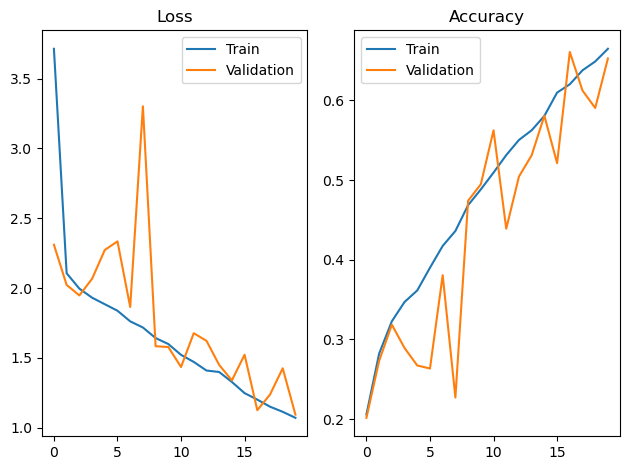

In [11]:
# Loss plot
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.legend()

# Display plots
plt.tight_layout()
plt.show()

In [12]:
# Save the model
model.save('model.h5')

In [8]:
# Load the model
model = keras.models.load_model('model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


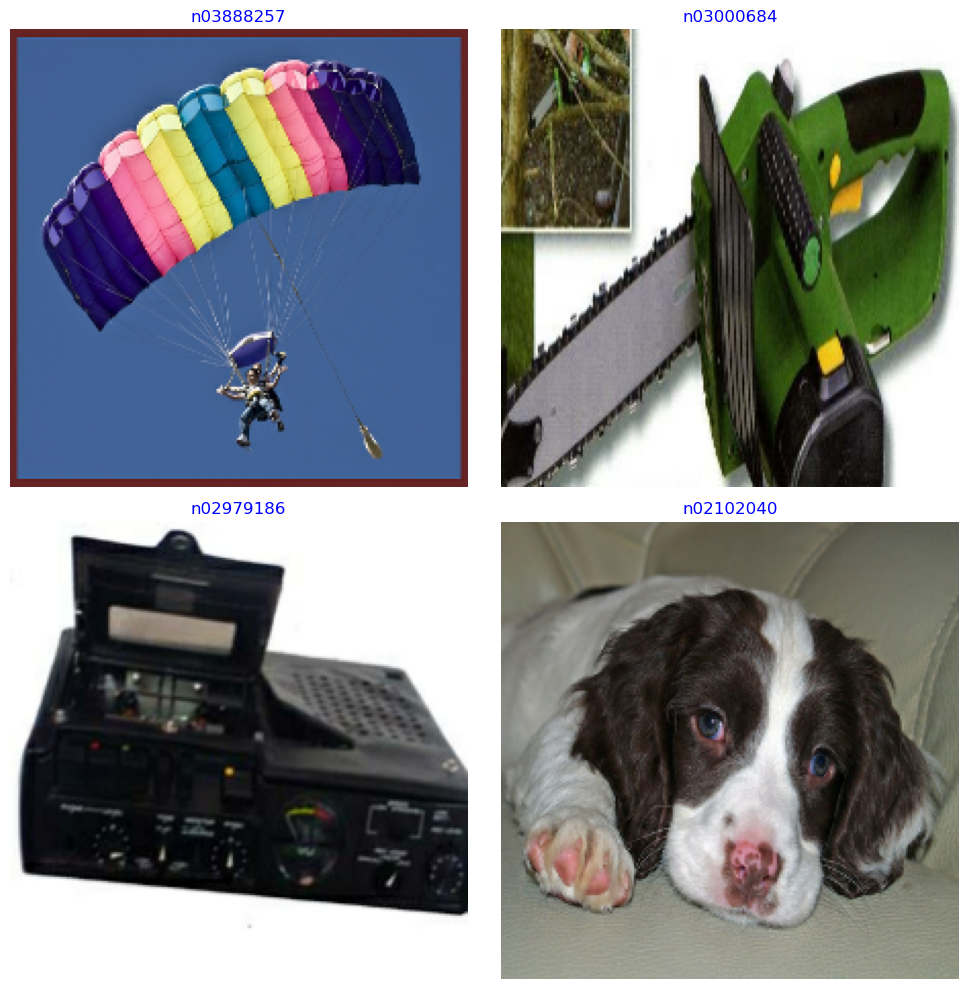

In [9]:
# Check results predicted by the model
plt.figure(figsize=(10, 10))

for images, labels in valid_iterator:
    prediction = [np.argmax(p) for p in model.predict(images[:10])]
    break

# Output images and predictions
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)

    # Scale image if it has range [0, 1]
    img = images[i]
    if img.max() <= 1.0:
        img = (img * 255).astype("uint8")
    plt.imshow(img)
    plt.title(text_labels[prediction[i]], color='blue' if prediction[i] == np.argmax(labels[i]) else 'red')
    plt.axis("off")

# Display plots
plt.tight_layout()
plt.show()